# K-Means clustering in 35 lines of python

### Intro
### Clustering is an [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) technique for finding similarity in your data. Want to find people that are similar? Cluster them into young hipsters, tech nerds, baby boomers, etc.
For example: If you were to cluster points on a two dimensional plane, your clusters would be groupings of your points that are in close physical proximity to one another.

Image - before  
Image - after  


### In this guide we're going to implement the core concepts of a k-means clustering algorithm.

The core of our algorithm is:
  1. randomly choose n cluster centroids.
  2. repeat the next steps until convergence (until your clusters stop changing):
  
      a. assign each data point to a cluster according to the nearest cluster centroid.  
      b. compute new centroids based on the mean of all points in the cluster.
      
In general, before clustering, you will want to scale your features so some dimensons don't end up dominating others.  
In this guide, we will be using [pandas](http://pandas.pydata.org/) simplify data manipulation.  
Also if you just want the code, [it's here](https://github.com/dmlicht/intro-to-k-means-clustering/blob/master/cluster.py).

It's worth noting, we can make our code faster and smaller with [scipy's distance calculations](https://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html), but I think doing so would hide the simple and important distance concept.

Finally, do not use this code in your programs! It is just for education and its SUPER SLOW. You can use [sklearns built in clustering algorithm](http://scikit-learn.org/stable/modules/clustering.html#k-means), it's faster, better supported, and will cost you less code. If you've never worked with sklearn before, [it's easy to get started]()

### Let's look at the whole thing, then we can dig into the important parts

In [17]:
from numpy import square, sqrt, setdiff1d

CLUSTER = "cluster"

def cluster(frame, n_clusters=5, n_iter=1000, distance_func=_dist):
    cols = setdiff1d(scaled.columns.tolist(), [CLUSTER]) # exclude the cluster column from distance computations
    centroids = frame.sample(n_clusters) # randomly pick clusters. There are other ways to pick.
    ii = 0
    while True:
        ii += 1
        print('cluster round: ', ii)
        frame[CLUSTER] = _cluster_assignments(frame[cols], centroids[cols])
        old_centroids = centroids.copy(deep=True)
        centroids = scaled.groupby(CLUSTER).mean()
        if old_centroids[cols].equals(centroids[cols]) or ii > n_iter:
            break
    return frame[CLUSTER]

def _cluster_assignments(frame, centroids):
    return scaled.apply(lambda x: _find_closest(x, centroids), axis=1) # assign each point to a cluster

def _find_closest(point, points):
    distances = points.apply(_dist_from(point), axis=1)
    return distances.reset_index().sort_values(by=0).iloc[0].name

def _dist_from(point):
    return lambda x: _dist(x, point)

def _dist(point_one, point_two):
    return sqrt(square((point_one - point_two)).sum())

## Let's look at the most important components of the algorithm
 * seed cluster centroids
 * assign points to clusters
 * recompute cluster centroids
 * stopping the algorithm

### Seeding cluster centroids
We randomly pick n points from our dataset to be our initial centroids using [`DataFrame.sample`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html)

    centroids = frame.sample(n_clusters)

### Assigning points to clusters
This is where the meat of our algorithm lives. To assign a point to a cluster, we measure it's distance from each cluster centroid. We choose the cluster corresponding to the centroid with the smallest distance from our point.

    def _cluster_assignments(frame, centroids):
        return scaled.apply(lambda x: _find_closest(x, centroids), axis=1) # assign each point to a cluster
        
the `scaled.apply` line calls `_find_closest` once for each datapoint, passing in the datapoint and the collection of cluster centroids.

    def _find_closest(point, points):
        distances = points.apply(_dist_from(point), axis=1)
        return distances.reset_index().sort_values(by=0).iloc[0].name
        
the `points.apply` returns a collection of distances between our datapoint and the cluster centroids. In the next line we sort the colletion by distance and return the cluster number corresponding to the shortest distance. 

`_cluster_assignments(frame[cols], centroids[cols])` returns a column containing the cluster assignments for each datapoint.

### recompute cluster centroids

Pandas makes recomputing cluster centroids super easy. [`groupby`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) allows us to arrange subcollections based on some values in our table. We can then operate on the subcollections individually. We use `groupby` to split up our data by the current cluster, then compute the average `x` and `y` points for each cluster. Those become our new centroids. Pretty concise. Thanks for being beautiful pandas.

    centroids = scaled.groupby(CLUSTER).mean()

### Stopping the algorithm

We should stop the algorithm when:
  * the clusters stop changing
  * we've run the max number of iterations
  
We check if the clusters stop changing with:

    old_centroids = centroids.copy(deep=True)
    centroids = scaled.groupby(CLUSTER).mean()
    if old_centroids[cols].equals(centroids[cols]) ...:
    
We check if we've surpassed our max number of iterations with:
   
    if ... ii > n_iter:

## OK, let's run this badboy

### Generate some random data to cluster

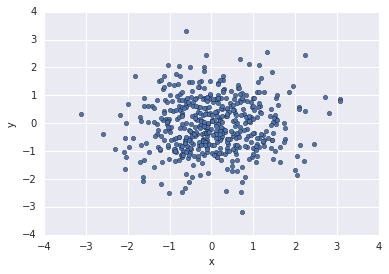

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns #just to pretty things up a little bit
%matplotlib inline

random_frame = pd.DataFrame(np.random.randn(500, 2), columns=["x", "y"])
random_frame.plot(kind='scatter', x='x', y='y')

### Run our cluster code

In [18]:
scaled = random_frame / random_frame.max()
random_frame["cluster"] = cluster(scaled, n_iter=10)

cluster round:  1
cluster round:  2
cluster round:  3
cluster round:  4
cluster round:  5
cluster round:  6
cluster round:  7
cluster round:  8
cluster round:  9
cluster round:  10
cluster round:  11


### Plot our result

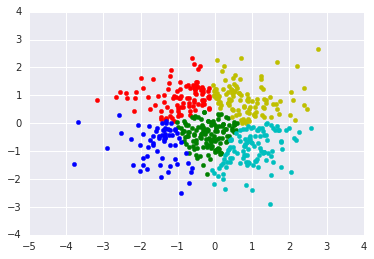

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

color_codes = {
    0: 'r',
    1: 'g',
    2: 'b',
    3: 'y',
    4: 'c'
}

def scatter_plot_colored(frame):
    for (cluster, color) in color_codes.items():
        rows = frame[frame["cluster"] == cluster]
        plt.scatter(rows["x"], rows["y"], color=color)
    plt.show()
    
scatter_plot_colored(random_frame)

### Conclusion
And voila, that's it! There are many things to consider when building and using clustering algorithms, but, we won't dig into them now. Some things you could think about for later are:

  - How to choose cluster centroids
  - Running your cluster several times so you don't end up less desirable convergence
  - When to stop your algorithm
  - How to choose the number of clusters to use
  - Choosing a different distance function
  - many more things!